# Custom Geo-Hierarchical MMM with Splines

This tutorial shows how to build a custom Marketing Mix Model (MMM) by combining PyMC-Marketing components with plain PyMC modeling.

We will build a model with:

- hierarchical media effects across geos,
- a spline-based time-varying intercept,
- Fourier seasonality,
- and hierarchical control effects for `event_1` and `event_2`.

The focus is model specification and motivation, with compact diagnostics.

## Why this custom model?

The multidimensional MMM tutorial shows hierarchical geos with the high-level `MMM` class. Here we go one layer lower and assemble a custom model from components.

This is useful when you want model structures that are not exposed by default, for example:

- spline baselines,
- custom pooling structures,
- and bespoke combinations of deterministic terms.

We will reuse the same synthetic geo dataset from the multidimensional tutorial so we can focus on model design.

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from patsy import dmatrix
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.fourier import YearlyFourier
from pymc_marketing.paths import data_dir

warnings.filterwarnings("ignore", category=UserWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed: int = sum(map(ord, "mmm_custom_splines"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Load and prepare data

We use `mmm_multidimensional_example.csv` (two geos, two channels, two controls).

To keep sampling stable in this custom model, we scale media and target by geo-level maxima.

In [2]:
data_path = data_dir / "mmm_multidimensional_example.csv"
data_df = pd.read_csv(data_path, parse_dates=["date"])

date_index = np.sort(data_df["date"].unique())
geo_names = sorted(data_df["geo"].unique())
channel_columns = ["x1", "x2"]
control_columns = ["event_1", "event_2"]

channel_data = (
    data_df.set_index(["date", "geo"])[channel_columns]
    .to_xarray()
    .to_array("channel")
    .transpose("date", "geo", "channel")
)

control_data = (
    data_df.set_index(["date", "geo"])[control_columns]
    .to_xarray()
    .to_array("control")
    .transpose("date", "geo", "control")
)

target_data = (
    data_df.set_index(["date", "geo"])["y"].to_xarray().transpose("date", "geo")
)

channel_scale = channel_data.max("date")
target_scale = target_data.max("date")

channel_scaled = channel_data / channel_scale
target_scaled = target_data / target_scale

coords = {
    "date": date_index,
    "geo": geo_names,
    "channel": channel_columns,
    "control": control_columns,
}

data_df.head()

,date,geo,x1,x2,event_1,event_2,y
0,2022-06-06,geo_a,5527.640078,0.000000,0,0,2647.596355
1,2022-06-06,geo_b,8849.257500,8063.918386,0,0,682.406280
2,2022-06-13,geo_a,6692.655692,0.000000,0,0,5020.823907
3,2022-06-13,geo_b,9073.817994,9354.014585,0,0,3753.104897
4,2022-06-20,geo_a,7124.016733,0.000000,0,0,6184.322132


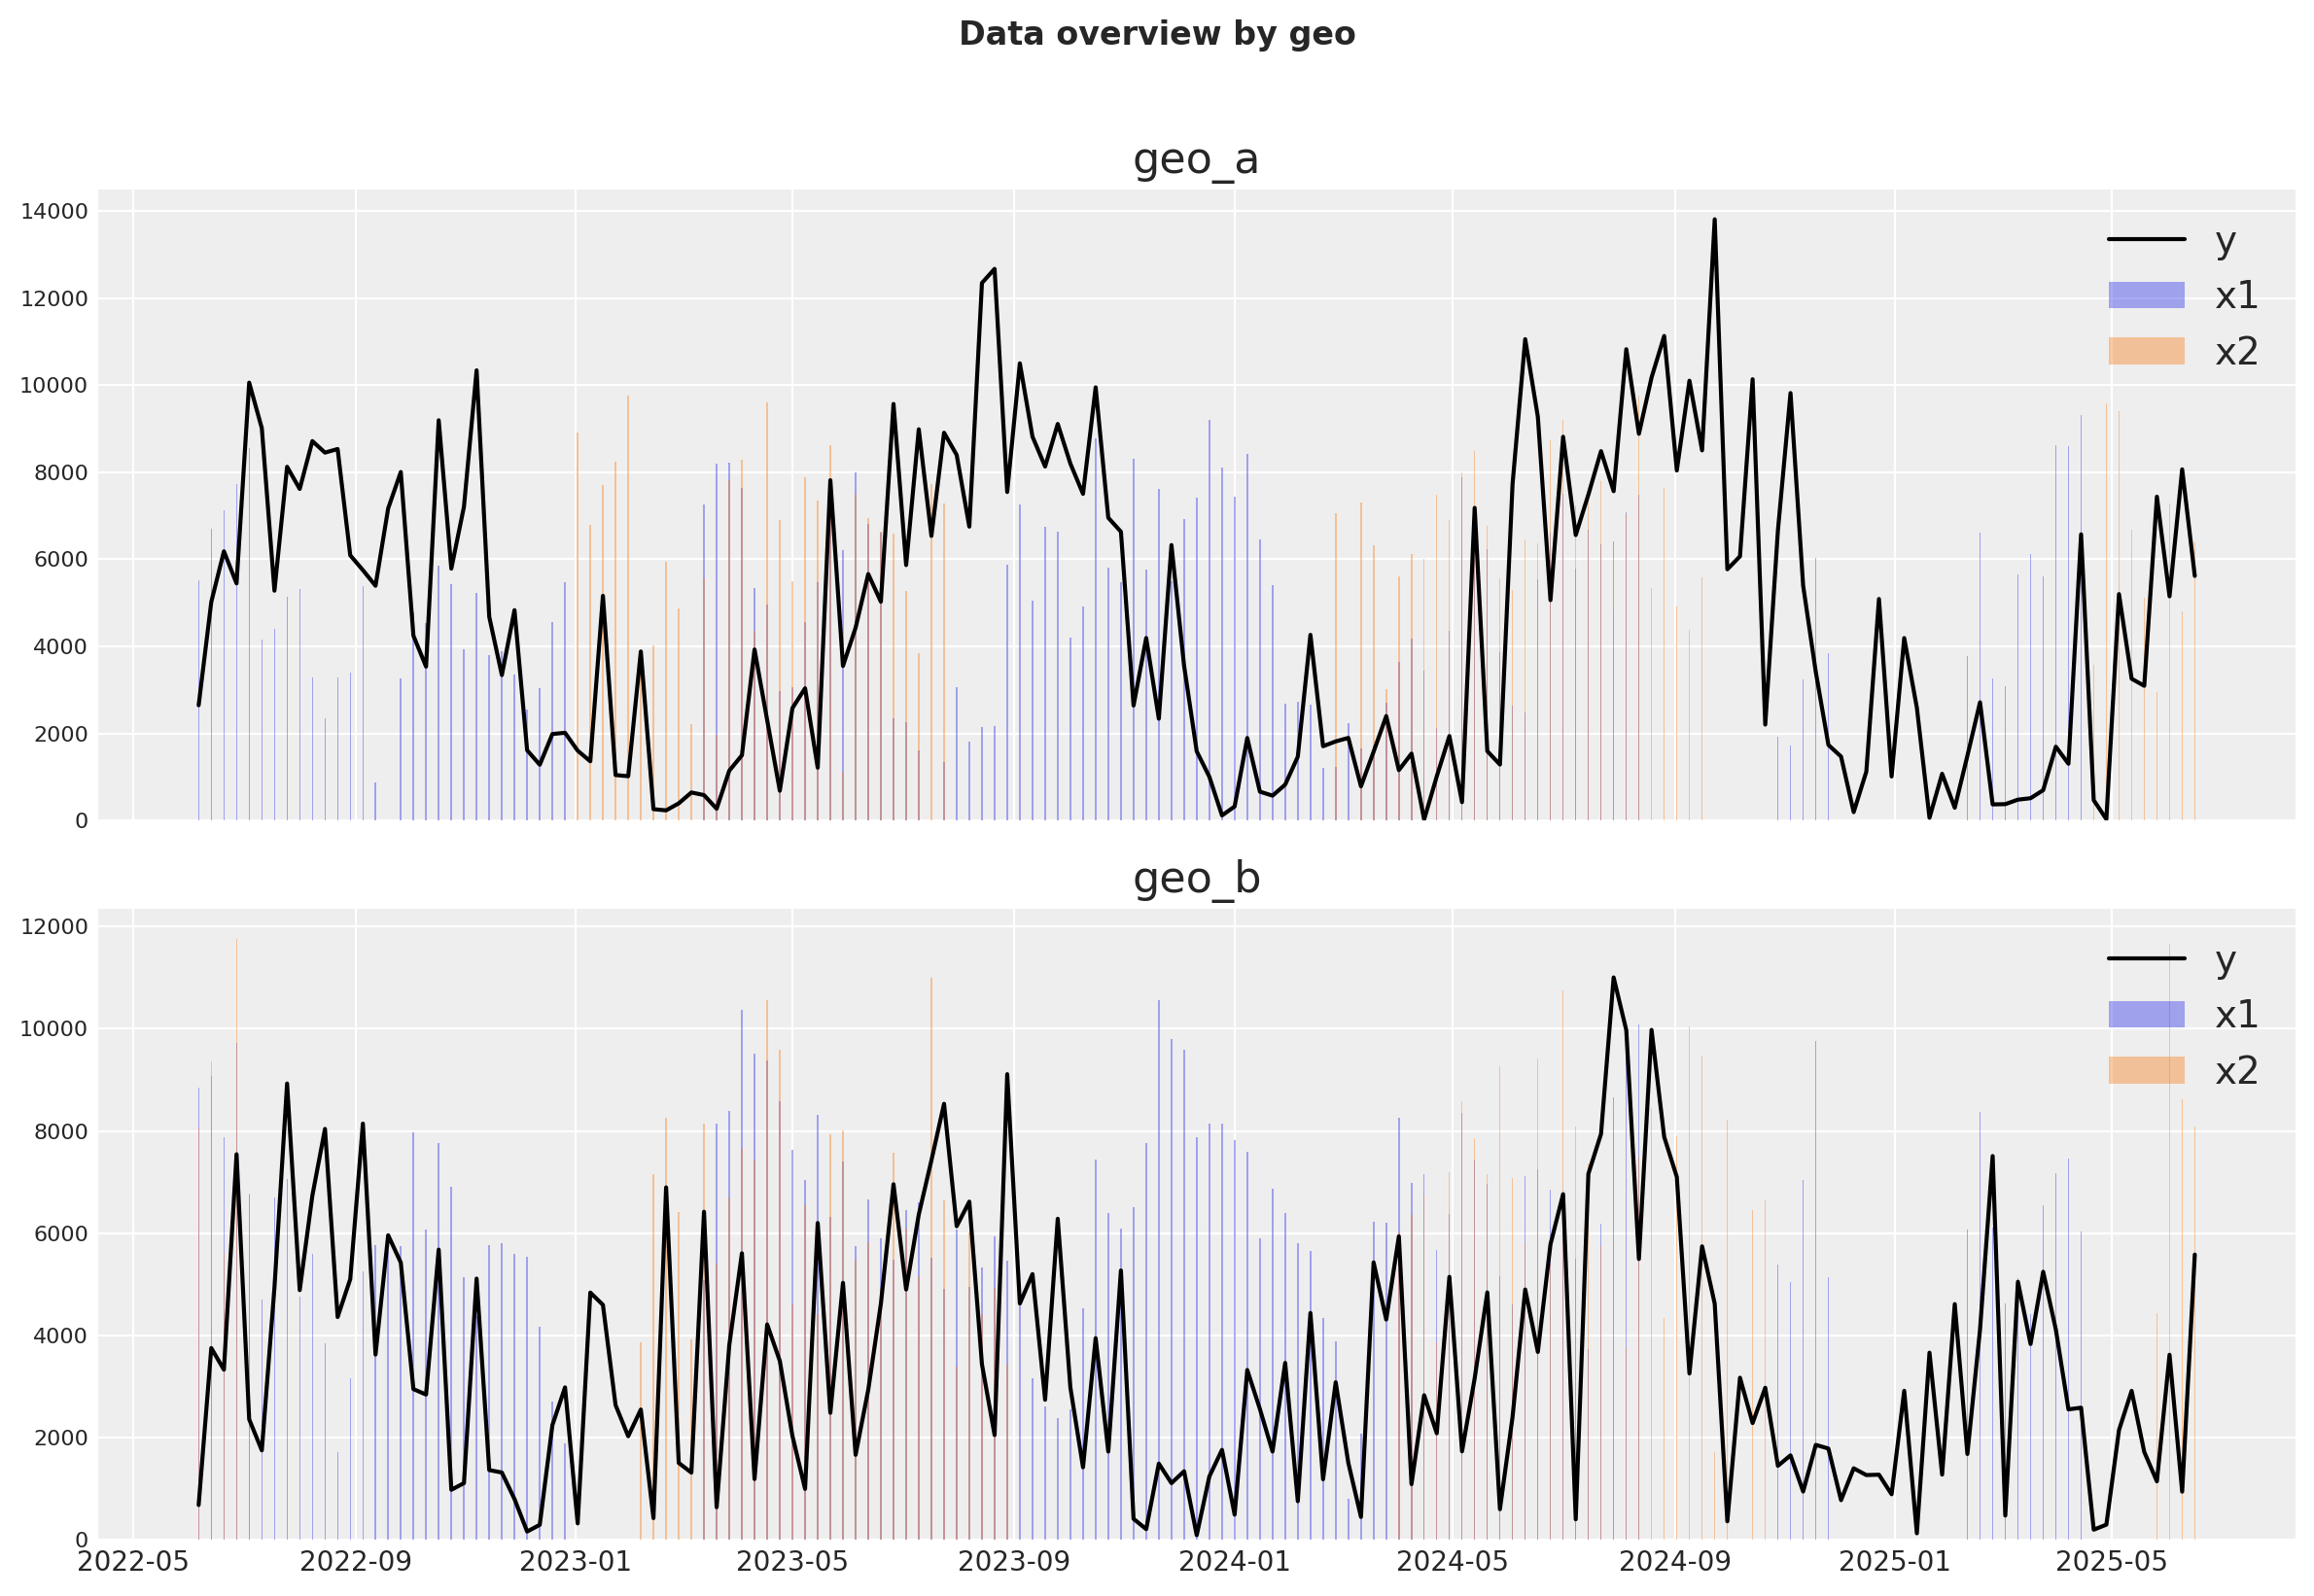

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for ax, geo in zip(axes, geo_names, strict=True):
    plot_df = data_df.query("geo == @geo")
    ax.plot(plot_df["date"], plot_df["y"], color="black", label="y")
    ax.bar(plot_df["date"], plot_df["x1"], alpha=0.4, label="x1")
    ax.bar(plot_df["date"], plot_df["x2"], alpha=0.4, label="x2")
    ax.set_title(geo)
    ax.legend(loc="upper right")

fig.suptitle("Data overview by geo", y=1.02, fontweight="bold")
plt.tight_layout()

## Spline basis for a time-varying intercept

Instead of a static intercept, we let baseline demand vary smoothly over time with cubic B-splines.

We then put a hierarchical prior on spline coefficients:

- each geo gets its own spline weights,
- but all geos share hyperpriors, enabling partial pooling.

In [4]:
time_idx = np.arange(len(date_index), dtype=float)

n_knots = 8
knot_list = np.percentile(time_idx, np.linspace(0, 100, n_knots + 2))[1:-1]

spline_basis = np.asarray(
    dmatrix(
        "bs(t, knots=knots, degree=3, include_intercept=True) - 1",
        {"t": time_idx, "knots": knot_list},
    )
)

coords["spline"] = np.arange(spline_basis.shape[1])
spline_basis.shape

## Custom model specification

We now assemble the model from components.

Key choices:

- **Media effects**: adstock + logistic saturation from PyMC-Marketing components.
- **Seasonality**: Fourier terms with geo-specific coefficients.
- **Controls**: hierarchical coefficients for `event_1` and `event_2` over geos.
- **Baseline**: hierarchical spline intercept over geos.

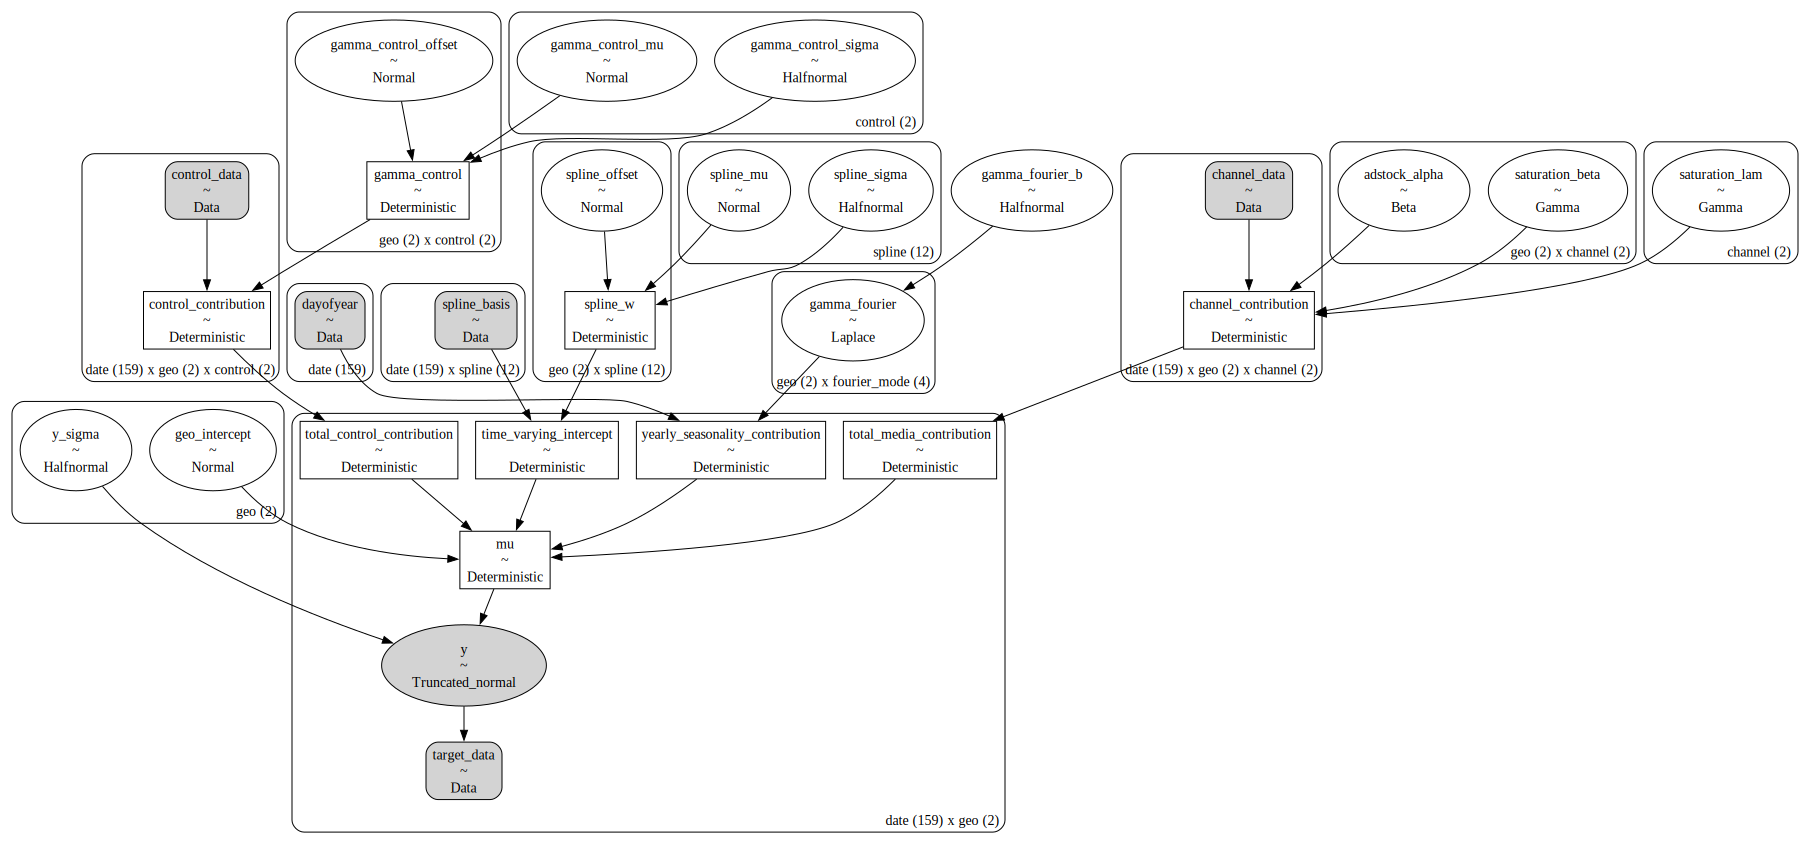

In [5]:
adstock = GeometricAdstock(
    l_max=8,
    priors={
        "alpha": Prior("Beta", alpha=2, beta=5, dims=("geo", "channel")),
    },
)

saturation = LogisticSaturation(
    priors={
        "lam": Prior("Gamma", mu=0.5, sigma=0.25, dims="channel"),
        "beta": Prior("Gamma", mu=0.25, sigma=0.10, dims=("geo", "channel")),
    }
)

yearly_fourier = YearlyFourier(
    n_order=2,
    prefix="fourier_mode",
    variable_name="gamma_fourier",
    prior=Prior(
        "Laplace",
        mu=0,
        b=Prior("HalfNormal", sigma=0.2),
        dims=("geo", "fourier_mode"),
    ),
)

with pm.Model(coords=coords) as custom_mmm:
    channel_data_ = pm.Data(
        "channel_data",
        channel_scaled.transpose("date", "geo", "channel"),
        dims=("date", "geo", "channel"),
    )
    control_data_ = pm.Data(
        "control_data",
        control_data.transpose("date", "geo", "control"),
        dims=("date", "geo", "control"),
    )
    target_data_ = pm.Data(
        "target_data", target_scaled.transpose("date", "geo"), dims=("date", "geo")
    )
    dayofyear_ = pm.Data(
        "dayofyear", pd.DatetimeIndex(date_index).dayofyear.values, dims="date"
    )
    spline_basis_ = pm.Data("spline_basis", spline_basis, dims=("date", "spline"))

    # Hierarchical spline coefficients over geos
    spline_mu = pm.Normal("spline_mu", mu=0, sigma=0.25, dims="spline")
    spline_sigma = pm.HalfNormal("spline_sigma", sigma=0.25, dims="spline")
    spline_offset = pm.Normal("spline_offset", mu=0, sigma=1, dims=("geo", "spline"))
    spline_w = pm.Deterministic(
        "spline_w",
        spline_mu + spline_offset * spline_sigma,
        dims=("geo", "spline"),
    )

    time_varying_intercept = pm.Deterministic(
        "time_varying_intercept",
        pm.math.dot(spline_basis_, spline_w.T),
        dims=("date", "geo"),
    )

    # Media transformation: adstock then saturation
    adstocked_media = adstock.apply(channel_data_, dims=("geo", "channel"))
    channel_contribution = pm.Deterministic(
        "channel_contribution",
        saturation.apply(adstocked_media, dims=("geo", "channel")),
        dims=("date", "geo", "channel"),
    )
    total_media_contribution = pm.Deterministic(
        "total_media_contribution",
        channel_contribution.sum(axis=-1),
        dims=("date", "geo"),
    )

    # Hierarchical controls across geos
    gamma_control_mu = pm.Normal("gamma_control_mu", mu=0, sigma=0.5, dims="control")
    gamma_control_sigma = pm.HalfNormal(
        "gamma_control_sigma", sigma=0.5, dims="control"
    )
    gamma_control_offset = pm.Normal(
        "gamma_control_offset", mu=0, sigma=1, dims=("geo", "control")
    )
    gamma_control = pm.Deterministic(
        "gamma_control",
        gamma_control_mu + gamma_control_offset * gamma_control_sigma,
        dims=("geo", "control"),
    )

    control_contribution = pm.Deterministic(
        "control_contribution",
        control_data_ * gamma_control,
        dims=("date", "geo", "control"),
    )
    total_control_contribution = pm.Deterministic(
        "total_control_contribution",
        control_contribution.sum(axis=-1),
        dims=("date", "geo"),
    )

    yearly_seasonality_contribution = pm.Deterministic(
        "yearly_seasonality_contribution",
        yearly_fourier.apply(dayofyear_),
        dims=("date", "geo"),
    )

    geo_intercept = pm.Normal("geo_intercept", mu=0.15, sigma=0.1, dims="geo")

    mu = pm.Deterministic(
        "mu",
        geo_intercept
        + time_varying_intercept
        + total_media_contribution
        + total_control_contribution
        + yearly_seasonality_contribution,
        dims=("date", "geo"),
    )

    y_sigma = pm.HalfNormal("y_sigma", sigma=0.2, dims="geo")

    pm.TruncatedNormal(
        "y",
        mu=mu,
        sigma=y_sigma,
        lower=0,
        observed=target_data_,
        dims=("date", "geo"),
    )

pm.model_to_graphviz(custom_mmm)

## Prior predictive check

A quick prior predictive check helps verify that our model can generate plausible trajectories before fitting.

Sampling: [adstock_alpha, gamma_control_mu, gamma_control_offset, gamma_control_sigma, gamma_fourier, gamma_fourier_b, geo_intercept, saturation_beta, saturation_lam, spline_mu, spline_offset, spline_sigma, y, y_sigma]


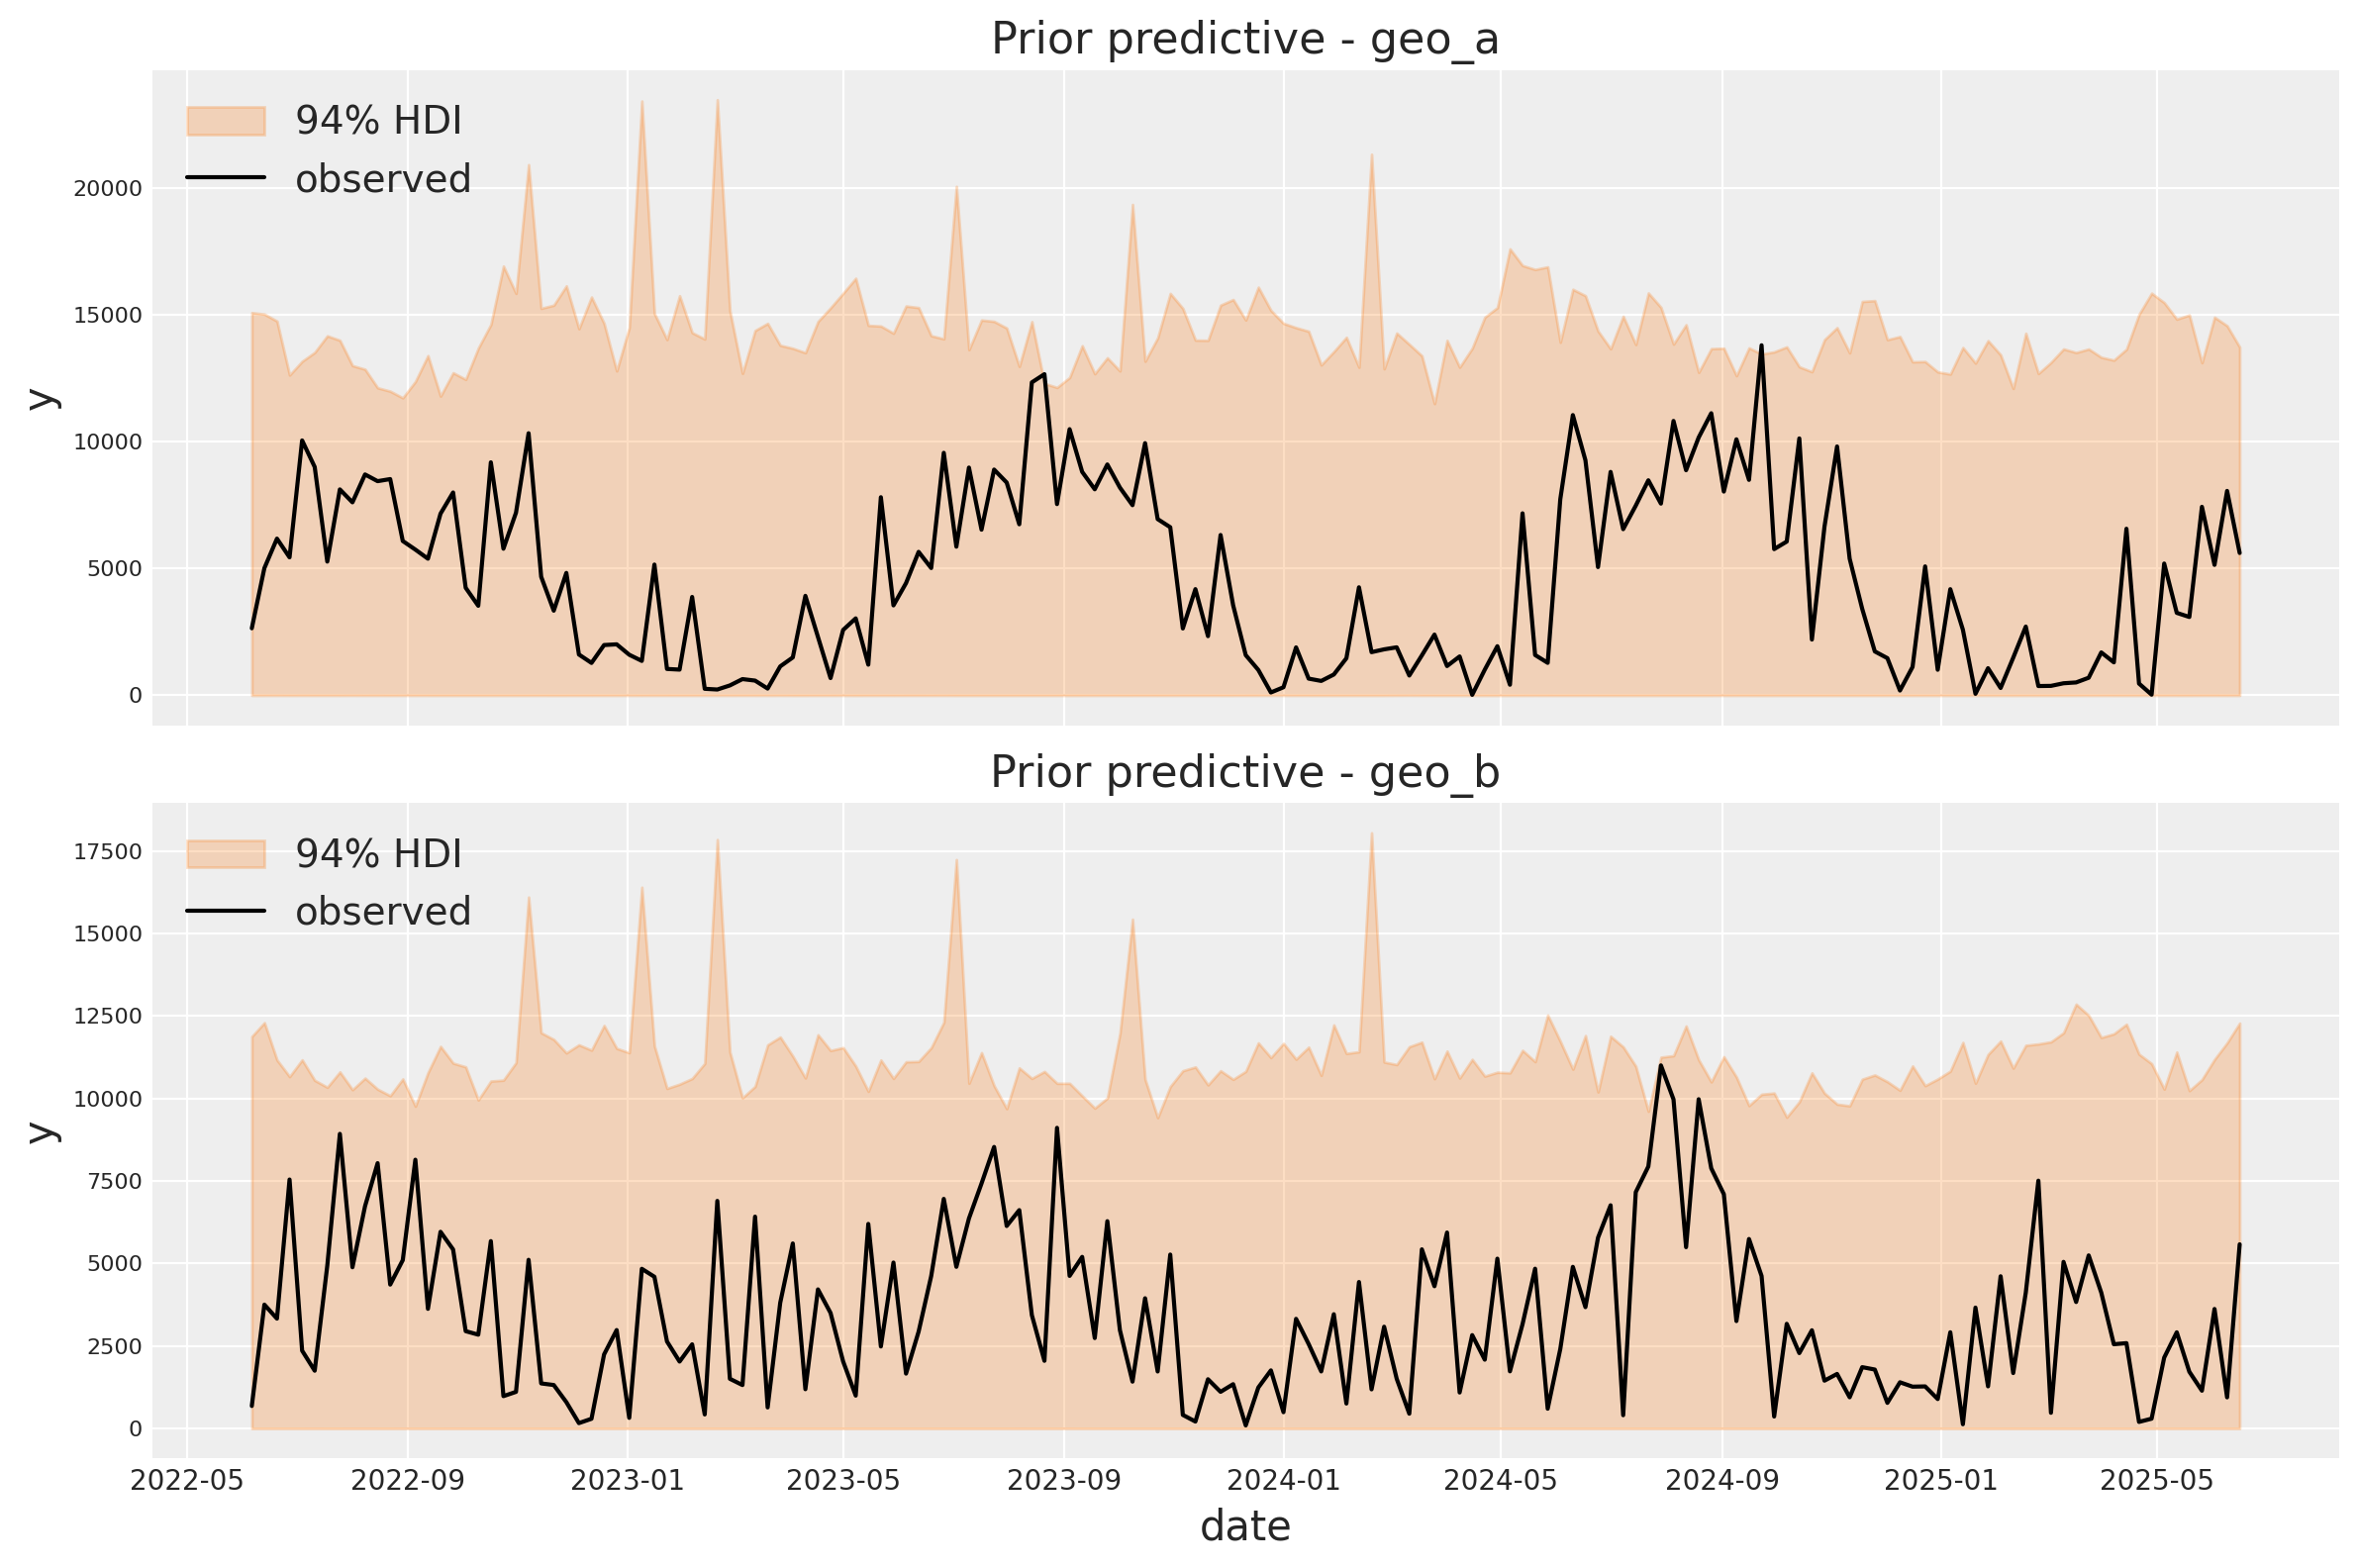

In [6]:
with custom_mmm:
    prior = pm.sample_prior_predictive(samples=300, random_seed=rng)

prior_ppc_original = prior.prior_predictive["y"] * target_scale

fig, axes = plt.subplots(nrows=len(geo_names), figsize=(12, 8), sharex=True)

for ax, geo in zip(axes, geo_names, strict=True):
    az.plot_hdi(
        x=date_index,
        y=prior_ppc_original.sel(geo=geo),
        hdi_prob=0.94,
        smooth=False,
        fill_kwargs={"alpha": 0.25, "label": "94% HDI"},
        ax=ax,
    )
    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
        label="observed",
    )
    ax.set_title(f"Prior predictive - {geo}")
    ax.legend(loc="upper left")

plt.tight_layout()

## Fit and posterior predictive

We keep the fitting section compact and focus on whether the specification behaves well:

- no divergences,
- stable chains,
- reasonable posterior predictive fit.

In [7]:
with custom_mmm:
    idata = pm.sample(
        chains=4,
        tune=1_000,
        draws=1_000,
        target_accept=0.95,
        random_seed=rng,
    )
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

idata.sample_stats["diverging"].sum(("chain", "draw"))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [spline_mu, spline_sigma, spline_offset, adstock_alpha, saturation_lam, saturation_beta, gamma_control_mu, gamma_control_sigma, gamma_control_offset, gamma_fourier_b, gamma_fourier, geo_intercept, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [y]


Output()

<xarray.DataArray 'diverging' ()> Size: 8B
array(0)

In [8]:
summary = az.summary(
    idata,
    var_names=[
        "gamma_control_mu",
        "gamma_control_sigma",
        "gamma_control",
        "spline_sigma",
        "y_sigma",
        "saturation_lam",
    ],
)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_control_mu[event_1],0.275,0.217,-0.155,0.679,0.004,0.005,3241.0,2231.0,1.0
gamma_control_mu[event_2],-0.086,0.194,-0.464,0.275,0.004,0.004,3003.0,2548.0,1.0
gamma_control_sigma[event_1],0.277,0.229,0.000,0.685,0.004,0.004,2328.0,2173.0,1.0
gamma_control_sigma[event_2],0.239,0.209,0.000,0.617,0.004,0.004,2042.0,2265.0,1.0
"gamma_control[geo_a, event_1]",0.245,0.135,-0.013,0.487,0.002,0.002,4207.0,3718.0,1.0
"gamma_control[geo_a, event_2]",-0.059,0.120,-0.279,0.179,0.002,0.002,4317.0,3539.0,1.0
"gamma_control[geo_b, event_1]",0.398,0.134,0.153,0.655,0.002,0.002,3865.0,3076.0,1.0
"gamma_control[geo_b, event_2]",-0.139,0.145,-0.406,0.136,0.002,0.002,4503.0,3571.0,1.0
spline_sigma[0],0.147,0.117,0.000,0.359,0.002,0.002,3071.0,2147.0,1.0
spline_sigma[1],0.145,0.118,0.000,0.361,0.002,0.002,3777.0,2576.0,1.0


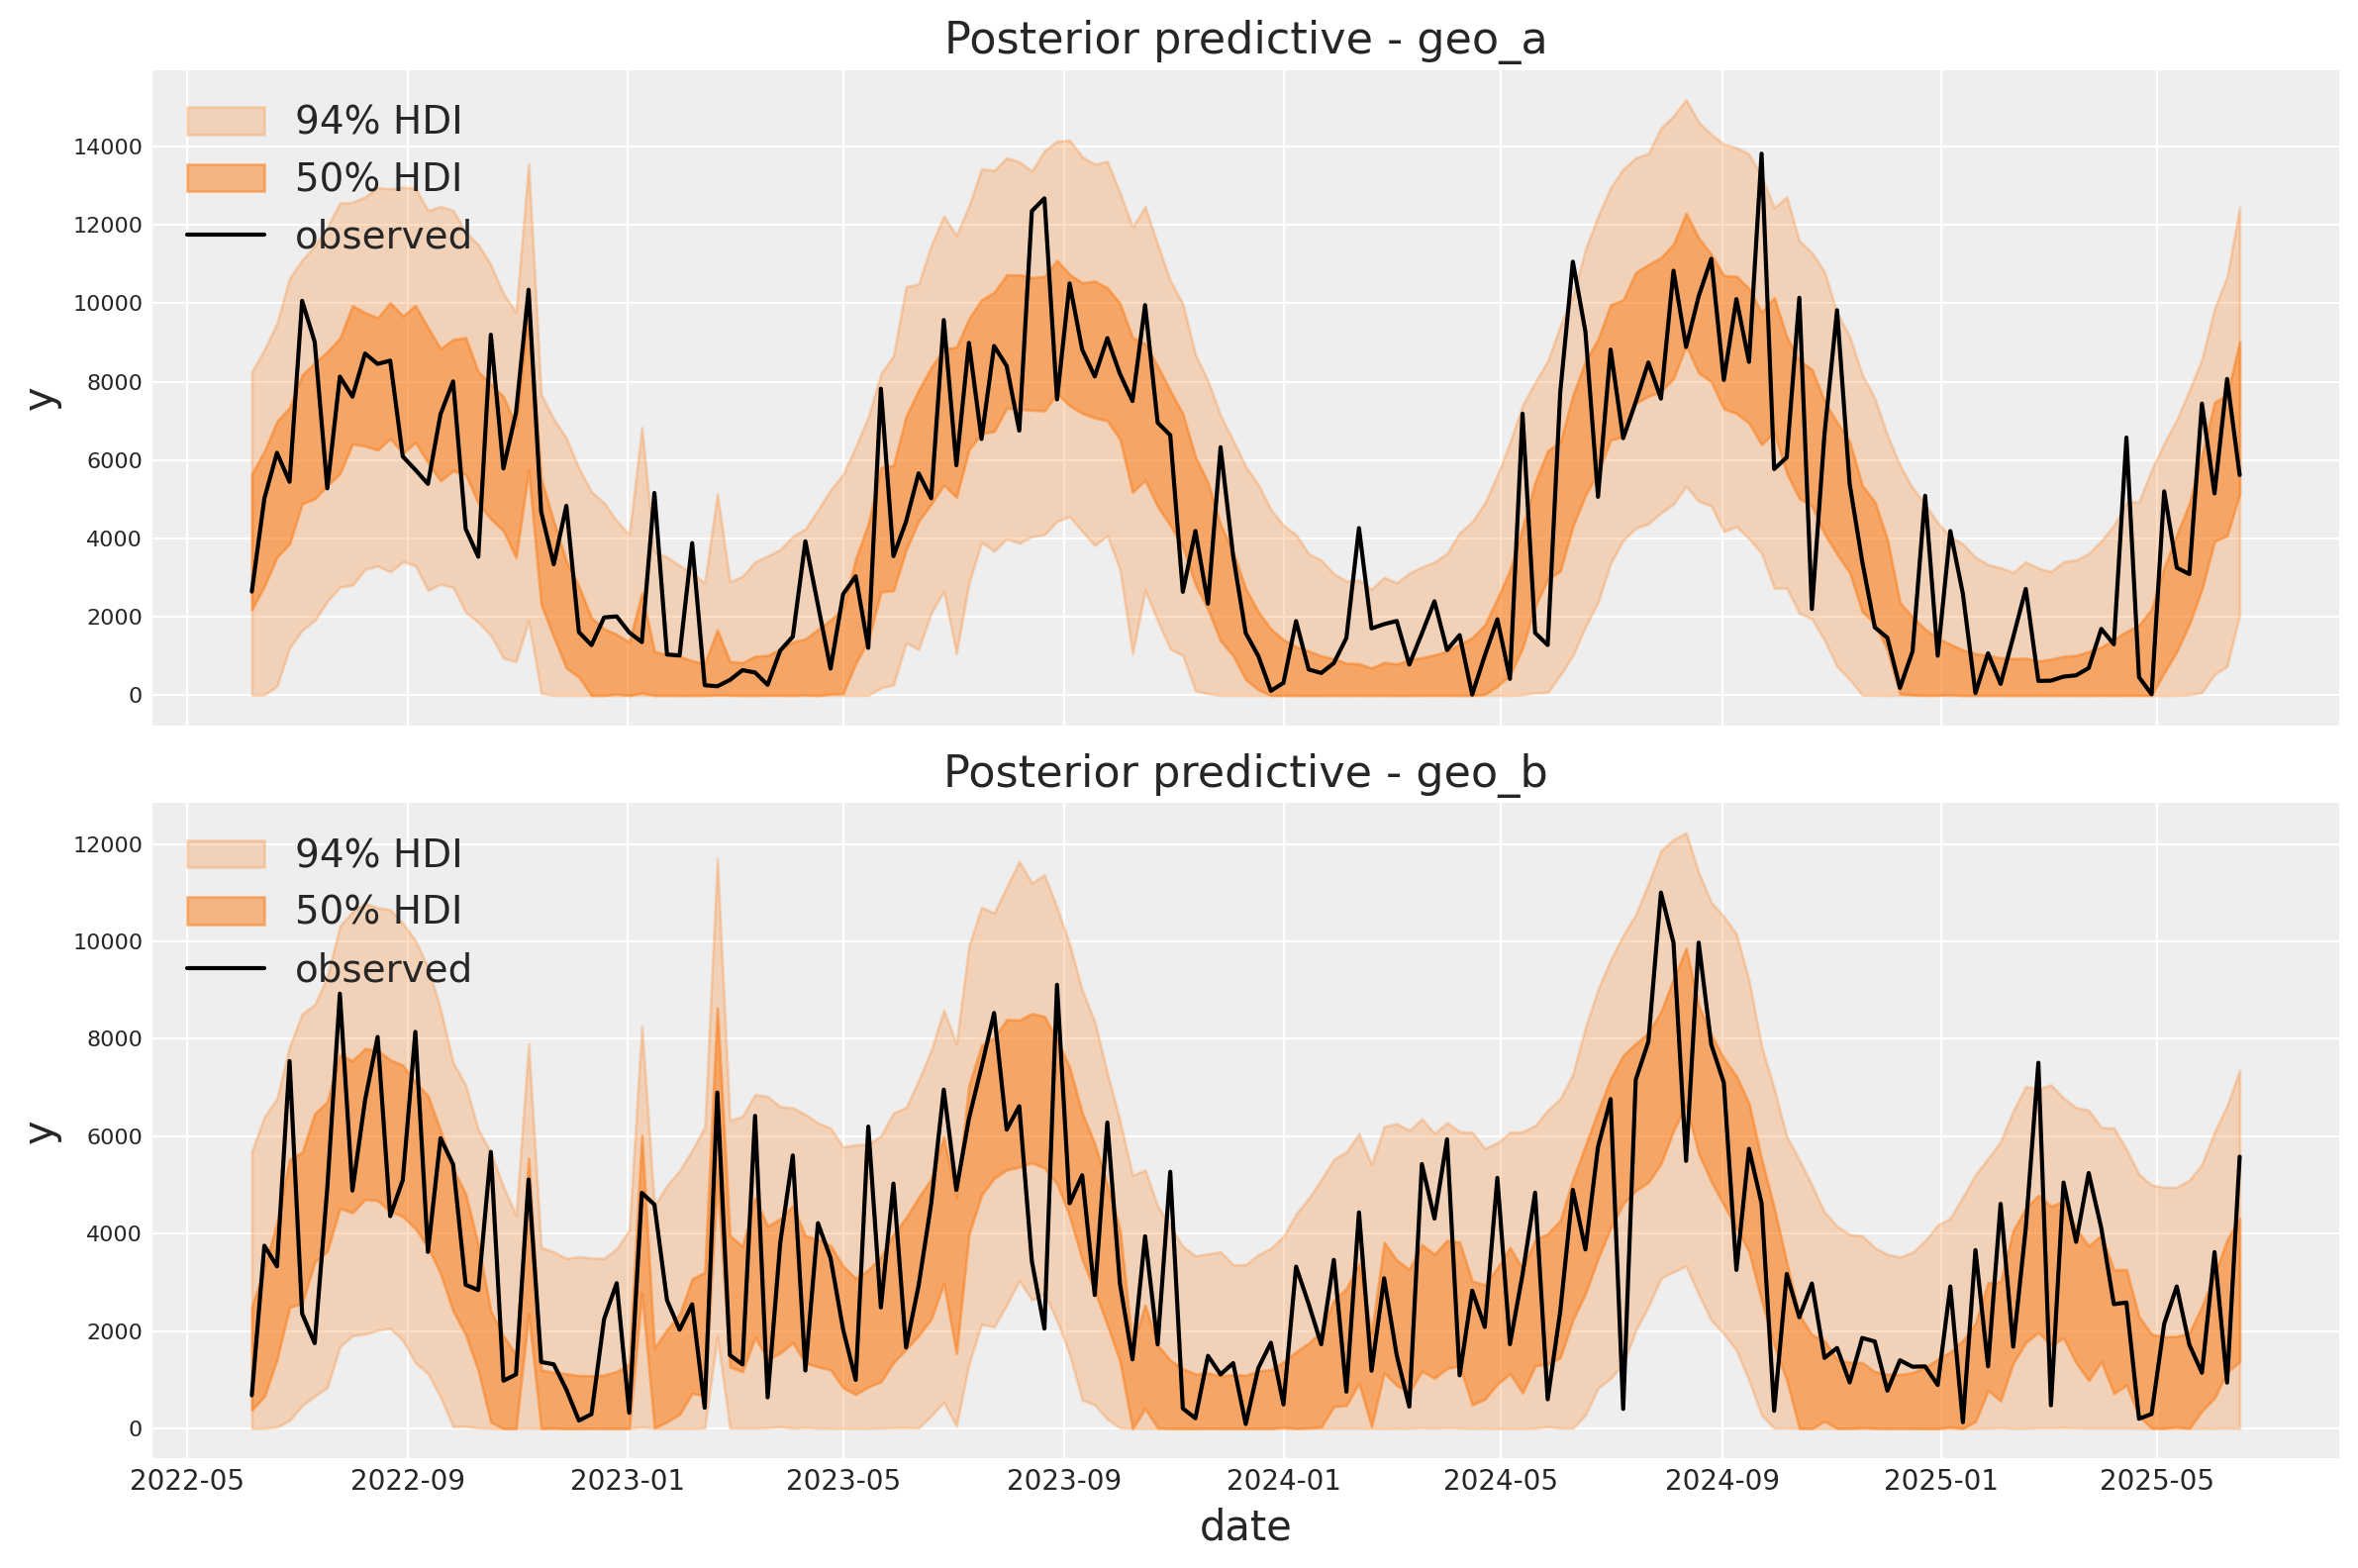

In [9]:
posterior_ppc_original = idata.posterior_predictive["y"] * target_scale

fig, axes = plt.subplots(nrows=len(geo_names), figsize=(12, 8), sharex=True)

for ax, geo in zip(axes, geo_names, strict=True):
    az.plot_hdi(
        x=date_index,
        y=posterior_ppc_original.sel(geo=geo),
        hdi_prob=0.94,
        smooth=False,
        fill_kwargs={"alpha": 0.25, "label": "94% HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=date_index,
        y=posterior_ppc_original.sel(geo=geo),
        hdi_prob=0.5,
        smooth=False,
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        ax=ax,
    )
    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
        label="observed",
    )
    ax.set_title(f"Posterior predictive - {geo}")
    ax.legend(loc="upper left")

plt.tight_layout()

## What this model demonstrates

This custom specification highlights how to combine PyMC-Marketing components and custom PyMC structure:

- **Hierarchical geo structure** for media and controls,
- **Spline baseline** for smooth long-run variation,
- **Fourier seasonality** for periodic behavior,
- and a clean additive decomposition in a single probabilistic model.

From here, you can iterate on priors, pooling assumptions, and the likelihood for your specific use case.